In [ ]:
import sys
sys.path.append('../../')

In [ ]:
from SynRBL.rsmi_utils import load_database, save_database

art1 = load_database('../../Data/Validation_set/artificial_data_1/mcs_based_reactions.json.gz')
art2 = load_database('../../Data/Validation_set/artificial_data_2/mcs_based_reactions.json.gz')

In [ ]:
import pandas as pd

test = pd.DataFrame(art1)

In [ ]:
test.shape

In [ ]:
test['reactants'].isnull().sum()

In [92]:
jaworski = load_database('../../Data/Validation_set/Jaworski/mcs_based_reactions.json.gz')

In [106]:
jaworski = load_database('../../Data/Validation_set/Jaworski/MCS/Condition_5.json.gz')
len(jaworski)

155

In [95]:
jaworski = load_database('../../Data/Validation_set/Jaworski/MCS/Final_Graph.json.gz')

In [99]:
pd.DataFrame(jaworski).dropna()

,smiles,boundary_atoms_products,nearest_neighbor_products,issue,Certainty,R-id,sorted_reactants,carbon_balance_check,mcs_results,old_reaction
0,"[O, C=O]","[[{'O': 0}], [{'C': 0}, {'C': 0}]]","[[{'C': 4}], [{'O': 5}, {'C': 2}]]",,True,USPTO_50K_8,"[O=C1C=CC(O)(C#Cc2ccccc2)C=C1, C=C1CC(=O)O1]",products,"[[#6]1(-,:[#6]=,:[#6]-,:[#6](-,:[#6]=,:[#6]-,:...",OC1(C=CC(=O)C=C1)C#Cc1ccccc1.C=C1CC(=O)O1>>CC(...
1,"[None, C[SiH](C)C]","[None, [{'Si': 1}]]","[None, [{'C': 2}]]",,True,USPTO_50K_14,"[O=Cc1ccccc1, C=CC[Si](C)(C)C]",products,"[[#8]=,-;!@[#6]-&!@[#6]1:&@[#6]:&@[#6]:&@[#6]:...",O=Cc1ccccc1.C[Si](C)(C)CC=C>>OC(CC=C)c1ccccc1
2,[NC=O],[[{'C': 1}]],[[{'C': 23}]],,True,USPTO_50K_31,[CCOC(=O)N1CC[C@H]2[C@H]1[C@H](CCO[Si](C)(C)C(...,reactants,[[#6]12-&@[#6]-&@[#6]-&@[#7](-&@[#6]-&@1-&@[#6...,[H][C@]12CCN(C(=O)OCC)[C@]1([H])[C@H](CCO[Si](...
3,"[C, None]","[[{'C': 0}], None]","[[{'O': 4}], None]",,True,USPTO_50K_32,"[C=C1O[C@H](OC)C[C@@H]2OC(=O)CC12, O]",products,[[#8]-[#6]-[#6]-[#6]1-[#8]-[#6](-[#6]-[#6]-1-[...,CO[C@@H]1C[C@@H]2OC(=O)CC2C(=C)O1.O>>OC1C[C@@H...
4,[CC[SiH](CC)CC.CO],"[[{'O': 8}, {'Si': 2}]]","[[{'C': 22}, {'O': 7}]]",,False,USPTO_50K_35,[CC[Si](CC)(CC)O[C@@]1(C2=C[C@H]3CC=C[C@H]3C2)...,products,[[#6](-[#6]-[#6]-[#8]-[#6])-[#6]-[#6]-[#6]-[#6...,[H][C@]12CC=C[C@@]1([H])CC(=C2)[C@@]1(CCC[C@H]...
...,...,...,...,...,...,...,...,...,...,...
150,"[None, O.O, None]","[None, [{'O': 0}, {'O': 1}], None]","[None, [{'C': 1}, {'C': 5}], None]",,False,USPTO_50K_64,"[N[C@@H](CO)c1ccccc1, O=CCCCC=O, C#N]",balanced,[[#7]-[#6](-[#6]-[#8])-[#6]1:[#6]:[#6]:[#6]:[#...,N[C@@H](CO)C1=CC=CC=C1.O=CCCCC=O.[H]C#N>>N#C[C...
151,"[CC, None]","[[{'C': 1}], None]","[[{'O': 2}], None]",,True,USPTO_50K_229,[CCOC(=O)Cc1csc(-c2ccc(C(CC)(CC)c3ccc(C=CC(O)(...,products,[[#6]-&!@[#6]-&!@[#6](-&!@[#6]-&!@[#6])(-&!@[#...,CCOC(=O)Cc1csc(n1)-c1ccc(cc1C)C(CC)(CC)c1ccc(C...
152,"[OBO, O]","[[{'B': 1}], [{'O': 0}]]","[[{'C': 3}], [{'O': 0}]]",,True,USPTO_50K_245,"[OB(O)c1ccc2c(c1F)Cc1c(F)cccc1-2, OO]",balanced,[[#6]1:&@[#6]:&@[#6]:&@[#6]2:&@[#6](:&@[#6]:&@...,OB(O)c1ccc-2c(Cc3c-2cccc3F)c1F.OO>>Oc1ccc-2c(C...
153,"[None, Cl.Cl]","[None, [{'Cl': 1}, {'Cl': 0}]]","[None, [{'C': 6}, {'S': 1}]]",,False,USPTO_50K_270,"[CC1(C)OB(c2ccc(N)cc2)OC1(C)C, O=S(=O)(Cl)CCCCl]",balanced,[[#6]-&!@[#6]1(-&!@[#6])-&@[#8]-&@[#5](-&@[#8]...,CC1(C)OB(OC1(C)C)c1ccc(N)cc1.ClCCCS(Cl)(=O)=O>...


In [96]:
len(jaworski)

155

In [76]:
golden = load_database('../../Data/Validation_set/golden_dataset/MCS/MCS_Impute.json.gz')

In [77]:
golden

[{'smiles': [None, '[CH2:14]=[CH2:15]'],
  'boundary_atoms_products': [None, [{'C': 0}]],
  'nearest_neighbor_products': [None, [{'C': 3}]],
  'issue': '',
  'Certainty': True,
  'R-id': 'golden_dataset_1',
  'sorted_reactants': ['[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=[CH2:8]',
   '[CH3:9][CH:10]([NH2:11])[CH:12]([OH:13])[CH:14]=[CH2:15]'],
  'carbon_balance_check': 'products',
  'mcs_results': ['[#6]-&!@[#6](=&!@[#8])-&!@[#6]-&!@[#16]-&!@[#6]-&!@[#6]=&!@[#6]',
   '[#6](-&!@[#8])-&!@[#6](-&!@[#7])-&!@[#6]'],
  'old_reaction': '[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=[CH2:8].[NH2:11][CH:10]([CH3:9])[CH:12]([OH:13])[CH:14]=[CH2:15]>>[CH:14](=[CH:7][CH2:6][S:5][CH2:4][C:2]([CH3:1])=[O:3])[CH:12]([OH:13])[CH:10]([NH2:11])[CH3:9]',
  'rules': ['append O to C-C bond', 'default single bond'],
  'new_reaction': '[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=[CH2:8].[NH2:11][CH:10]([CH3:9])[CH:12]([OH:13])[CH:14]=[CH2:15]>>[CH:14](=[CH:7][CH2:6][S:5][CH2:4][C:2]([CH3:1])=[O:3])[CH

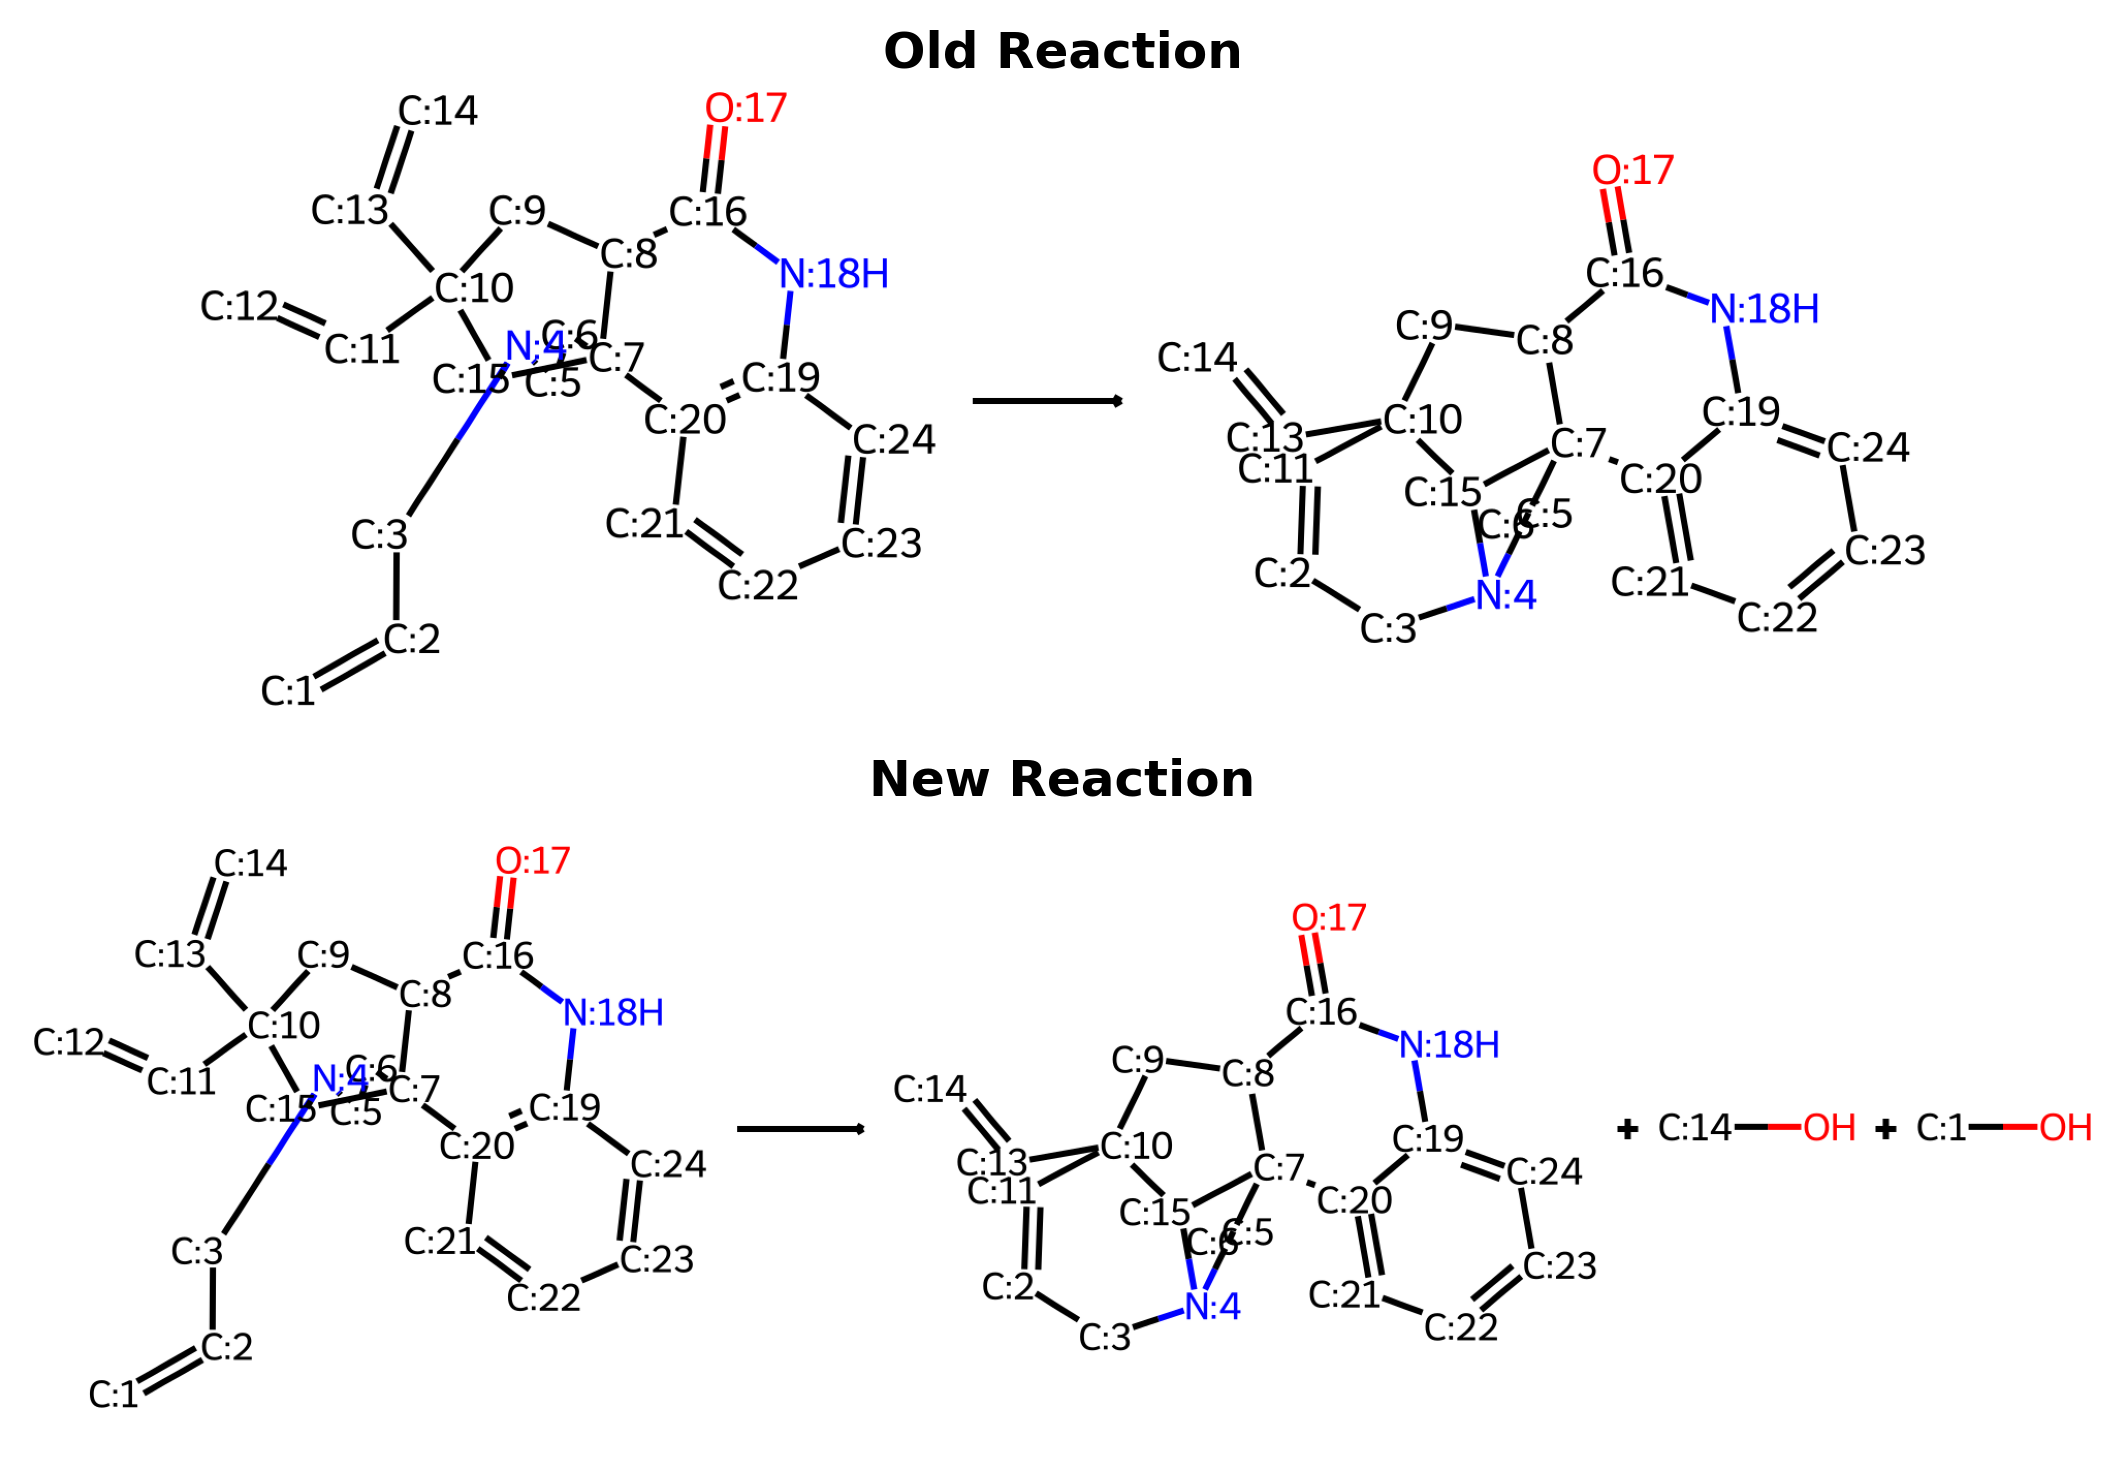

In [91]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(golden[207], 'old_reaction', 'new_reaction', compare=True, show_atom_numbers=False)

In [72]:
rule = load_database('../../Data/Rules/rules_manager.json.gz')
rule

[{'formula': 'O', 'smiles': '[O]', 'Composition': {'O': 1, 'Q': 0}},
 {'formula': 'Cl2', 'smiles': 'ClCl', 'Composition': {'Cl': 2, 'Q': 0}},
 {'formula': 'N3-',
  'smiles': '[N-]=[N+]=[N-]',
  'Composition': {'N': 3, 'Q': -1}},
 {'formula': 'H', 'smiles': '[H]', 'Composition': {'Q': 0, 'H': 1}},
 {'formula': 'F2', 'smiles': 'FF', 'Composition': {'Q': 0, 'F': 2}},
 {'formula': 'Cl2', 'smiles': 'ClCl', 'Composition': {'Q': 0, 'Cl': 2}},
 {'formula': 'Br2', 'smiles': 'BrBr', 'Composition': {'Q': 0, 'Br': 2}},
 {'formula': 'I2', 'smiles': 'II', 'Composition': {'Q': 0, 'I': 2}},
 {'formula': 'H+', 'smiles': '[H+]', 'Composition': {'Q': 1, 'H': 1}},
 {'formula': 'Na+', 'smiles': '[Na+]', 'Composition': {'Q': 1, 'Na': 1}},
 {'formula': 'Li+', 'smiles': '[Li+]', 'Composition': {'Q': 1, 'Li': 1}},
 {'formula': 'K+', 'smiles': '[K+]', 'Composition': {'Q': 1, 'K': 1}},
 {'formula': 'Ca2+', 'smiles': '[Ca+2]', 'Composition': {'Q': 2, 'Ca': 1}},
 {'formula': 'Mg2+', 'smiles': '[Mg+2]', 'Compositio

In [ ]:
import pandas as pd
jaworski = pd.read_csv('../../Data/Validation_set/golden_dataset.csv')

In [ ]:
uspto_1 = load_database('../../Data/Validation_set/USPTO_diff/mcs_based_reactions.json.gz')
uspto_rule_1 = load_database('../../Data/Validation_set/USPTO_diff/rule_based_reactions.json.gz')
uspto_2 = load_database('../../Data/Validation_set/USPTO_unbalance_class/mcs_based_reactions.json.gz')
uspto_rule_2 = load_database('../../Data/Validation_set/USPTO_unbalance_class/rule_based_reactions.json.gz')

In [ ]:
uspto_rule_1[0]

In [ ]:
art

In [ ]:
key_get = ['id', 'class', 'reactions']

In [ ]:
uspto_2.extend(uspto_rule_2)

In [ ]:
pd.DataFrame(uspto_2)[['id','class', 'reactions']].to_csv('../../Data/Validation_set/USPTO_unbalance_class.csv', index=False)

In [ ]:
pd.DataFrame(uspto_2)

In [ ]:
uspto_dff_1 =

In [ ]:
jaworski[jaworski.duplicated(subset=['reactions'], keep=False)]

In [ ]:
list_wrong = [11,213, 234, 221, 225, 227, 233, 239, 240, 241, 242, 249, 270, 273, 283, 366, 374, 375, 444, 449, 481, 635, 663]

In [ ]:
len(list_wrong)

In [ ]:
golden_wrong = [golden[i] for i in list_wrong]

In [ ]:
golden

In [ ]:
ground_truth

In [ ]:
ground_truth = golden.copy()

In [ ]:
import pandas as pd
ground_truth = pd.DataFrame(ground_truth)[['R-id', 'reactions']].to_dict(orient='records')

In [ ]:
ground_truth[630]['reactions'] = number_630
vis.plot_reactions(ground_truth[630], 'reactions', 'reactions', compare=False, savefig=False)

In [ ]:
# wrong reaction fix


number_444 = '[CH:17]=1[CH:18]=[CH:19][C:14](=[CH:15][CH:16]=1)[CH:12]([OH:13])[CH2:11][CH2:10][CH2:9][CH2:8][CH2:7][CH2:6][CH2:5][CH2:4][CH2:3][CH3:2].[OH-:1]>>[CH:17]=1[CH:18]=[CH:19][C:14](=[CH:15][CH:16]=1)[CH:12]([OH:13])[CH2:11][CH2:10][CH2:9][CH2:8][CH2:7][CH2:6][CH2:5][CH2:4][CH2:3][CH3:2].[OH-:1]'

number_449 = '[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][Br:6].[Mg:7]>>[CH3:1][C:2]([CH3:3])=[CH:4][CH2:5][Mg:7][Br:6]'

number_481  = '[CH:6]=1[CH:7]=[CH:8][CH:9]=[CH:10][C:5]=1[CH3:4].[O-:3][N+:2](=[O:1])[OH:11]>>[N+:2]([O-:3])(=[O:1])[C:8]1=[CH:7][CH:6]=[C:5]([CH3:4])[CH:10]=[CH:9]1.[OH:12]'


number_663 = '[CH:12]1=[C:11]([CH2:10][N:9]([CH2:17][C:18]2=[CH:19][CH:20]=[CH:21][CH:22]=[CH:23]2)[C:8]=3[CH:24]=[CH:25][CH:26]=[C:6]([CH:7]=3)[Br:29])[CH:16]=[CH:15][CH:14]=[CH:13]1.[CH2:3]1[CH2:4][CH2:5][CH:1]([CH2:2]1)[Br:27].[Mg:28]>>[CH2:2]1[CH2:3][CH2:4][CH2:5][CH:1]1[C:6]=2[CH:26]=[CH:25][CH:24]=[C:8]([CH:7]=2)[N:9]([CH2:17][C:18]=3[CH:19]=[CH:20][CH:21]=[CH:22][CH:23]=3)[CH2:10][C:11]=4[CH:16]=[CH:15][CH:14]=[CH:13][CH:12]=4.[Br:27][Mg:28][Br:29]'



In [ ]:
# wrong reaction rule based


number_621 ='[C:3](=[O:5])([CH2:2][CH3:1])[CH3:4].[NH2:8][N:7]([CH3:6])[C:9]1=[CH:10][CH:11]=[CH:12][CH:13]=[CH:14]1>>[CH:11]=1[CH:12]=[CH:13][CH:14]=[C:9]2[C:10]=1[C:2]([CH3:1])=[C:3]([CH3:4])[N:7]2[CH3:6].[NH3:8].[OH2:5]'

number_630 = '[CH2:7]([CH2:8][OH:9])[CH3:6].[Cl:1][C:2]([Cl:3])([Cl:4])[Cl:5].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10]([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1>>[CH2:7]([CH3:6])[CH2:8][Cl:5].[Cl:1][CH:2]([Cl:3])[Cl:4].[CH:11]1=[CH:12][CH:13]=[CH:14][CH:15]=[C:16]1[P:10](=[O:5])([C:17]2=[CH:18][CH:19]=[CH:20][CH:21]=[CH:22]2)[C:23]1=[CH:24][CH:25]=[CH:26][CH:27]=[C:28]1'

In [ ]:

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image

display(Reactions.ReactionFromSmarts(number_283, useSmiles=True))

vis.plot_reactions(golden[283], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)


In [ ]:
golden[621]['reactions']

In [ ]:
from SynRBL.SynChemImputer.appel_reaction import AppelReaction

appel = AppelReaction()


In [ ]:
golden[283]['reactions']

In [ ]:
Chem.MolFromSmiles('[C-:26]#[O+:27]')

In [ ]:
test ='[C-:26]#[O+:27].[CH3:19][C:18]([CH3:20])([CH3:21])[Si:15]([CH3:16])([CH3:17])[O:14][CH2:13][CH2:12][CH:11]1[CH:10]2[CH:1]([CH:25]=[CH:24][CH:22]1[OH:23])[CH2:2][CH2:3][N:4]2[C:5](=[O:6])[O:7][CH2:8][CH3:9].[NH3:27]>>[CH3:19][C:18]([CH3:20])([CH3:21])[Si:15]([CH3:16])([CH3:17])[O:14][CH2:13][CH2:12][CH:11]1[CH:22]=[CH:24][CH:25]([CH:1]2[CH2:2][CH2:3][N:4]([C:5](=[O:6])[O:7][CH2:8][CH3:9])[CH:10]12)[C:26](=[O:27])[NH2:27].[OH2:23]'

In [ ]:
vis.plot_reactions(golden[283], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [ ]:
save_database(ground_truth, '../../Data/Validation_set/golden_dataset/rule_based_ground_truth.json.gz')

In [ ]:
golden[630]['reactions']

In [ ]:
c1ccccc1P(c2ccccc2)c3ccccc3

In [ ]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(golden[630], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [ ]:
vis.plot_reactions(golden_wrong[16], 'reactions', 'new_reaction', compare=True, show_atom_numbers=False)

In [ ]:
# Jaworski class
jaworski = load_database('../../Data/Validation_set/Jaworski/rule_based_reactions.json.gz')
jaworski_167 = 'BrBr.CC1=C(C(OC)=O)C=CC=C1[N+]([O-])=O>>O=C(OC)C2=C(CBr)C([N+]([O-])=O)=CC=C2.Br'
jaworski_171 = 'CC1(O[C@@H]2COC([C@@H]2O1)O)C.Br[Mg]C=C.O>>CC1(O[C@@H]([C@H]([C@H](C=C)O)O1)CO)C.Br[Mg+][OH]'

In [ ]:
display(Reactions.ReactionFromSmarts(jaworski_171, useSmiles=True))

In [ ]:
import pandas as pd
ground_truth = jaworski.copy()
ground_truth = pd.DataFrame(ground_truth)[['R-id', 'reactions']].to_dict(orient='records')

In [ ]:
save_database(ground_truth, '../../Data/Validation_set/Jaworski/rule_based_ground_truth.json.gz')

In [ ]:
ground_truth[167]['reactions'] = jaworski_167
ground_truth[171]['reactions'] = jaworski_171

In [ ]:
ground_truth[167]

In [ ]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(ground_truth[171], 'reactions', 'reactions', compare=False, show_atom_numbers=False)